# Load raw data

In [1]:
# Hyperparameter
PRICE_FEATURE = False     # Add feature of monthly average price ?
NORMALIZATION= False      # Normalization ?
TIMESTEPS = 30            # Timesteps (1-33)

LAYER_PARAM = [(64, 0.5), (64, 0.5)]  # LSTM layers' parameters (units, dropout)

TRAIN_PARAM = {"batch_size":128, # Train parameters
               "verbose":2,
               "epochs":60}
ROUND = False              # round the prediction ?

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import backend
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split

sales = pd.read_csv('data/sales_train.csv', parse_dates=['date'], infer_datetime_format=True, dayfirst=True)
test = pd.read_csv('data/test.csv')

shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
item_cats = pd.read_csv('data/item_categories.csv')

sales.head()

Using TensorFlow backend.


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sales.drop(['date','date_block_num','shop_id','item_id'], axis=1).describe()

,item_price,item_cnt_day
count,2935849.00,2935849.00
mean,890.85,1.24
std,1729.80,2.62
min,-1.00,-22.00
25%,249.00,1.00
50%,399.00,1.00
75%,999.00,1.00
max,307980.00,2169.00


# Explore data

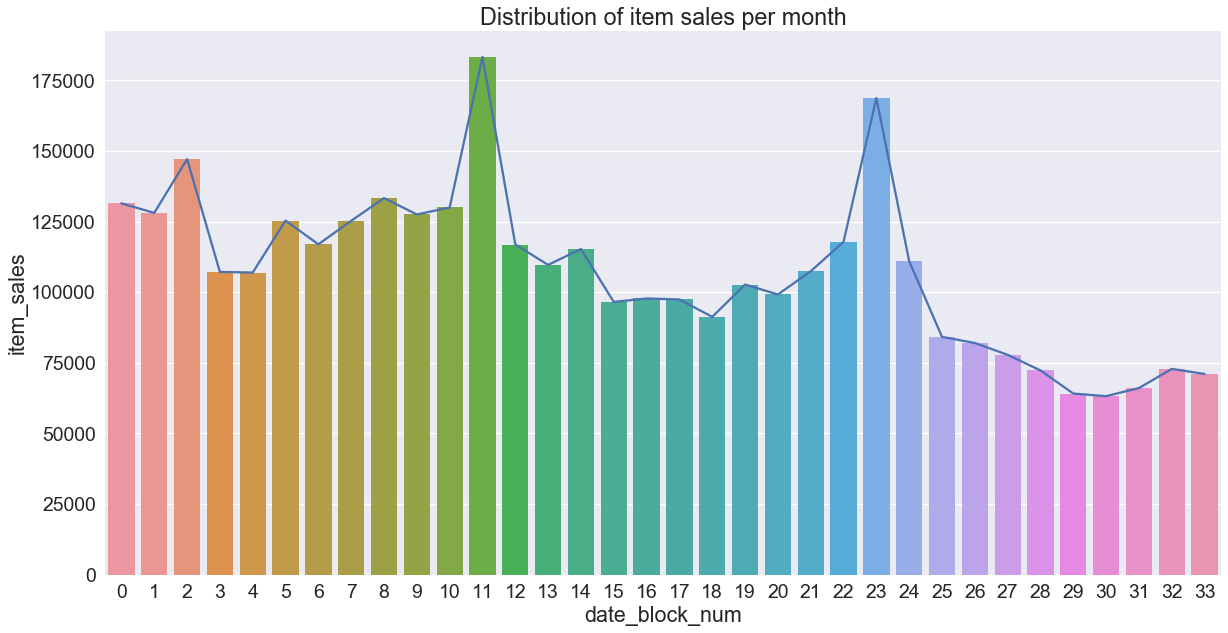

In [4]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("talk", font_scale=1.5)
sales_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.head()
sales_month.columns = ['date_block_num', 'item_sales']
sns.barplot(x ='date_block_num', y='item_sales', data=sales_month);
plt.plot(sales_month.item_sales)
plt.title('Distribution of item sales per month')
del sales_month

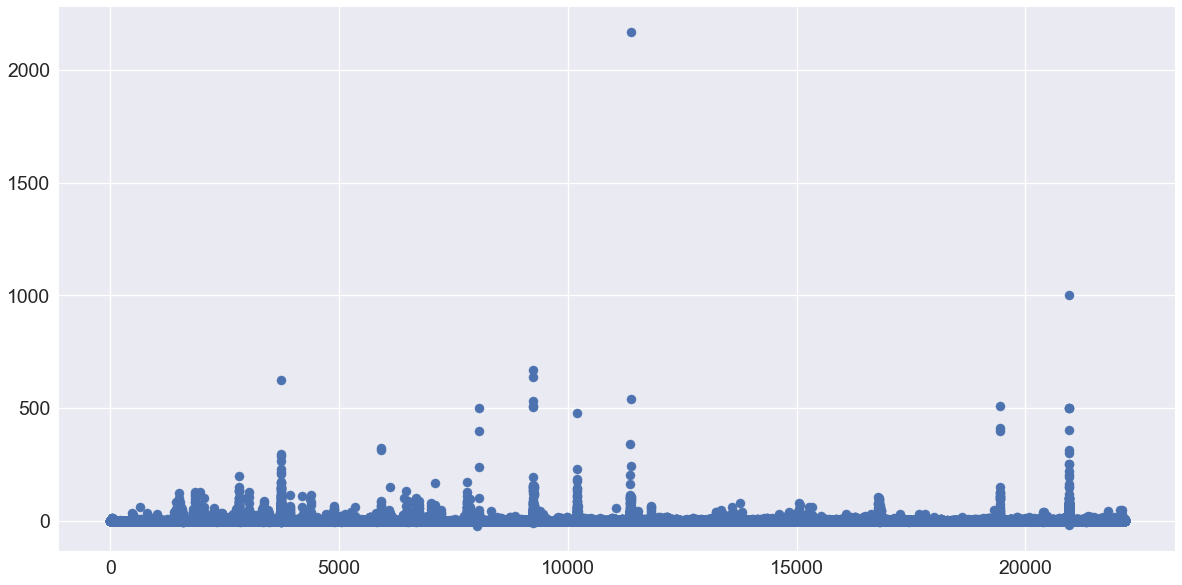

In [5]:
plt.figure(figsize=(20,10))
plt.scatter(sales.item_id, sales.item_cnt_day)

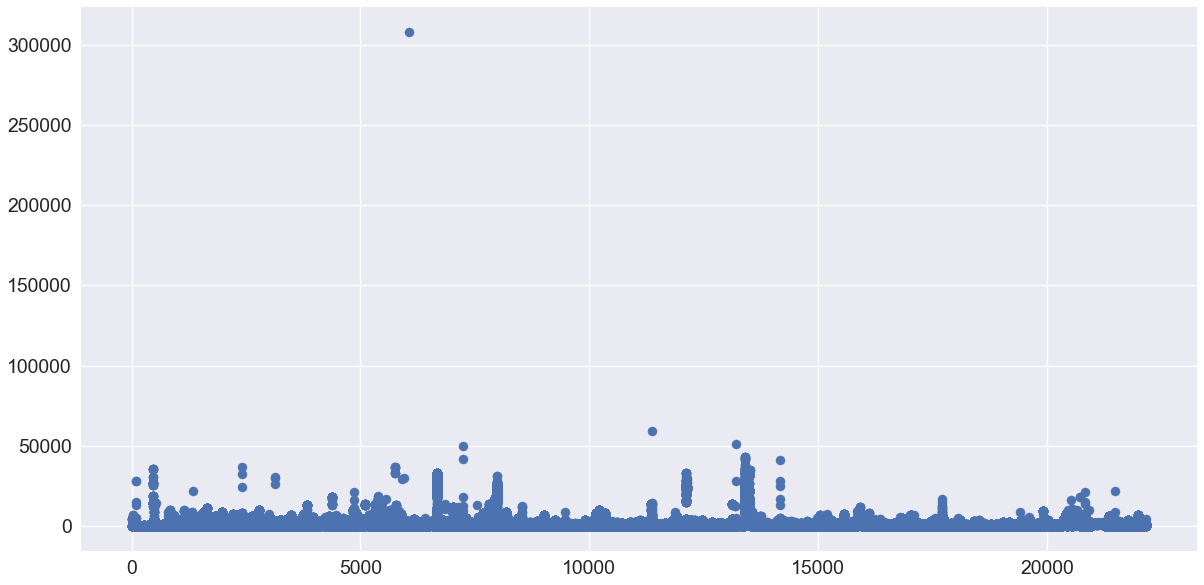

In [6]:
plt.figure(figsize=(20,10))
plt.scatter(sales.item_id, sales.item_price)

# Detect and clear outliers

In [7]:
# find and drop outliers
outliers = sales.loc[(sales.item_cnt_day > 1500) | (sales.item_price > 55000) | (sales.item_price <= 0)]
sales = sales.drop(outliers.index)
print(outliers)

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  2013-05-15               4       32     2973       -1.00          1.00
885138  2013-09-17               8       12    11365    59200.00          1.00
1163158 2013-12-13              11       12     6066   307980.00          1.00
2909818 2015-10-28              33       12    11373        0.91       2169.00


# Reshape dataframe

In [8]:
df_cnt = sales.groupby([sales.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
df_cnt = df_cnt[['date','item_id','shop_id','item_cnt_day']]
df_cnt = df_cnt.pivot_table(index=['item_id','shop_id'], columns='date', values='item_cnt_day', fill_value=0).reset_index()
df_cnt = pd.merge(test, df_cnt, on=['item_id','shop_id'], how='left').fillna(0.) # Merge the test items with sale history
df_cnt = df_cnt.drop(labels=['ID', 'shop_id', 'item_id'], axis=1) # Remove the categorical data
df_cnt.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [9]:
if PRICE_FEATURE:
    df_pri = sales.groupby([sales.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).mean().reset_index()
    df_pri = df_pri[['date','item_id','shop_id','item_price']]
    df_pri = df_pri.pivot_table(index=['item_id','shop_id'], columns='date', values='item_price', fill_value=0).reset_index()
    df_pri = pd.merge(test, df_pri, on=['item_id','shop_id'], how='left').fillna(0.) # Merge the test items with sale history
    df_pri = df_pri.drop(labels=['ID', 'shop_id', 'item_id'], axis=1) # Remove the categorical data
    df_pri.head()

# Normalization

In [10]:
if PRICE_FEATURE:
    pri = df_pri.values
    if NORMALIZATION:
        pri_min = np.min(pri)
        pri_gap = np.max(pri) - pri_min
        pri /= pri_gap
    pri = pri.reshape((pri.shape[0], pri.shape[1], 1))

cnt = df_cnt.values

if NORMALIZATION:
    cnt_min = np.min(cnt)
    cnt_gap = np.max(cnt) - cnt_min
    cnt /= cnt_gap
cnt = cnt.reshape((cnt.shape[0], cnt.shape[1], 1))

In [11]:
if PRICE_FEATURE:
    features = np.append(cnt, pri, axis=2)         # Merge cnt and price
else:
    features = cnt
print(features.shape)

(214200, 34, 1)


# Reshape the training data

In [12]:
train_X = []
train_y = []
recent_X = []
recent_y = []
test_X = []
end = features.shape[1]
for fea_timeline, cnt_timeline in zip(features, cnt):
    for i in range(0, end-TIMESTEPS-1):
        train_X.append(fea_timeline[i:i + TIMESTEPS])
        train_y.append(cnt_timeline[i + TIMESTEPS])
        
    recent_X.append(fea_timeline[end-TIMESTEPS-1:end-1])
    recent_y.append(cnt_timeline[end-1])
    
    test_X.append(fea_timeline[end-TIMESTEPS:end])

# set 20% recent data as cross validation and add merge the rest with trainning data
train_X_recent, valid_X, train_y_recent, valid_y = train_test_split(recent_X, recent_y, test_size=0.20, random_state=42)
train_X += train_X_recent
train_y += train_y_recent


train_X = np.array(train_X)
train_y = np.array(train_y)
print('train_X', train_X.shape)
print('train_y', train_y.shape)

valid_X = np.array(valid_X)
valid_y = np.array(valid_y)
print('valid_X', valid_X.shape)
print('valid_y', valid_y.shape)

test_X = np.array(test_X)
print('test_X', test_X.shape)

train_X (813960, 30, 1)
train_y (813960, 1)
valid_X (42840, 30, 1)
valid_y (42840, 1)
test_X (214200, 30, 1)


# Build the model

In [13]:
# Build the LSTM model
model = Sequential()
for i, (units, dropout) in enumerate(LAYER_PARAM):  # add LSTM layers
    return_sequences = (i != len(LAYER_PARAM)- 1)  # return_sequences = False at last layer
    if i == 0:  # First layer require input_shape
        model.add(LSTM(units, dropout=dropout, return_sequences=return_sequences, 
                       input_shape=(train_X.shape[1],train_X.shape[2])))
    else:
        model.add(LSTM(units, dropout=dropout, return_sequences=return_sequences))
model.add(Dense(1))

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

model.compile(optimizer='adam', loss = 'mse', metrics=[rmse])
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Train

In [14]:
earlystop = EarlyStopping(monitor='val_rmse', patience=4, verbose=0, mode='auto')
callbacks_list = [earlystop]
model_info = model.fit(train_X, train_y, callbacks=callbacks_list, **TRAIN_PARAM, validation_data=(valid_X, valid_y))

Train on 813960 samples, validate on 42840 samples
Epoch 1/60
 - 333s - loss: 4.8520 - rmse: 0.3757 - val_loss: 1.8468 - val_rmse: 0.3601
Epoch 2/60
 - 343s - loss: 4.4534 - rmse: 0.3627 - val_loss: 1.7607 - val_rmse: 0.3036
Epoch 3/60
 - 342s - loss: 4.2738 - rmse: 0.3615 - val_loss: 1.6756 - val_rmse: 0.3432
Epoch 4/60
 - 344s - loss: 4.3638 - rmse: 0.3626 - val_loss: 1.8026 - val_rmse: 0.3434
Epoch 5/60
 - 347s - loss: 4.1021 - rmse: 0.3608 - val_loss: 1.6733 - val_rmse: 0.3165
Epoch 6/60
 - 345s - loss: 4.1821 - rmse: 0.3633 - val_loss: 1.8977 - val_rmse: 0.3317


# Predict and write to csv

In [15]:
# Get the test set predictions
pred_y = model.predict(test_X)
if NORMALIZATION:
    pred_y = pred_y * cnt_gap + cnt_min
    
pred_y = pred_y.clip(0., 20.) # Required by kaggle

if ROUND:
    round_y = lambda x: x if np.abs(x-np.round(x)) > 0.05 else np.round(x)
    vfunc = np.vectorize(round_y)
    pred_y = vfunc(pred_y)

# Write to submission file
preds = pd.DataFrame(pred_y, columns=['item_cnt_month'])
preds.to_csv('submission.csv', index_label='ID')

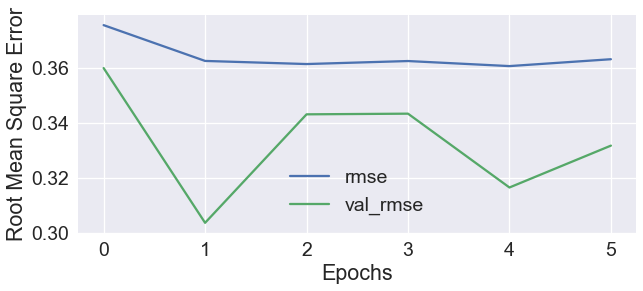

<Figure size 1440x720 with 0 Axes>

In [16]:
plt.figure(figsize=(10,4))
plt.plot(model_info.history['rmse'], label='rmse')
plt.plot(model_info.history['val_rmse'], label='val_rmse')
plt.xlabel("Epochs")
plt.ylabel("Root Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation RMSE Progression.png")

range(0, 30)


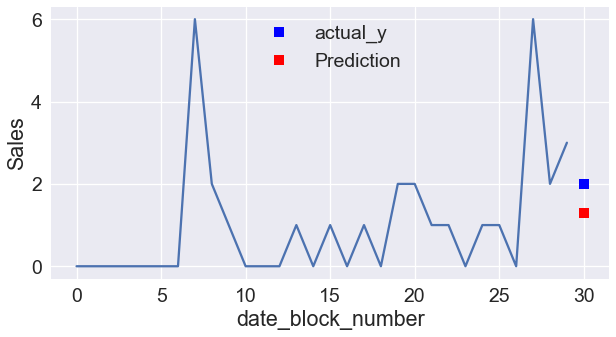

In [197]:
# Show a sample
item_id = 51
plt.figure(figsize=(10,5))
item_sales = valid_X[item_id:item_id+1]
actual_y = valid_y[item_id]
prediction = model.predict(item_sales)[0]

date_block = range(len(valid_X[0]))
print(date_block)
plt.plot(date_block, item_sales[0])
plt.plot(len(item_sales[0]), actual_y, 'bs', label='actual_y')
plt.plot(len(item_sales[0]), prediction, 'rs', label='Prediction')
plt.xlabel("date_block_number")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [152]:
print(item_id)

111
